## Tutorial mdfeature 


Author: Zofia Trstanova   


In [1]:
%pylab inline
#import metadynamics
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as image
from pyemma import msm
from scipy.interpolate import griddata
from matplotlib.pyplot import cm
import mdtraj as md
from ipywidgets import IntProgress
from IPython.display import display
import time
import numpy as np

import mdfeature.features as features

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13


## Initiating OpenMM to run or load a short trajectory

In [3]:
# Bunch of useful simulation parameters
steps = 100
iterations = 10000
beta = 1.0/(300.0*0.0083144621)

In [4]:
pdb_name = 'alanine.pdb'
pdb = PDBFile(pdb_name)
saving_file = 'trajectory.dcd'

forcefield = ForceField('amber14-all.xml', 'amber14/spce.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, constraints=HBonds)

integrator = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)
simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName('CPU'))
simulation.context.setPositions(pdb.positions)
simulation.context.setVelocitiesToTemperature(300*kelvin)



Features module contains functions to print the name of the torsions.

In [5]:
# check the loaded topology

print(pdb.topology)
topology = md.load(pdb_name).topology
print(topology)

table, bonds = topology.to_dataframe()
#print(table)

<Topology; 1 chains, 3 residues, 22 atoms, 21 bonds>
<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 33 bonds>


In [7]:
import mdfeature.features as features

phi = [4, 6, 8 ,14] #dihedral coordinates # [4, 6, 8 ,14]#[1, 6, 8, 14]
psi = [6, 8, 14, 16]

phi_name = features.get_name_torsion(phi, pdb_file=pdb_name, table=table)
psi_name = features.get_name_torsion(psi, pdb_file=pdb_name, table=table)

print('Long name')
print(phi_name)
print(psi_name)

phi_name_short = features.get_name_torsion(phi, pdb_file=pdb_name, table=table, format='short')
psi_name_short = features.get_name_torsion(psi, pdb_file=pdb_name, table=table, format='short')

print('Short name')
print(phi_name_short)
print(psi_name_short)

Long name
ACE1C-ALA2N-ALA2C-ALA2C
ALA2N-ALA2C-ALA2C-NME3N
Short name
1C-2N-2C-2C
2N-2C-2C-3N


In [12]:
# if False, dont run
run = False


if run: 
    mdinit = md.load_pdb(pdb_name)
    mdinit.save_dcd(saving_file)     
    simulation.reporters.append(DCDReporter(saving_file, steps, append=True))

    max_count = iterations
    bar = IntProgress(min=0, max=max_count) # instantiate the bar
    display(bar) # display the bar
    
    for i in range(iterations):
        
        bar.value += 1
        simulation.step(steps)

        state = simulation.context.getState(getEnergy=True, enforcePeriodicBox = False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        


## Load trajectory

In [13]:
traj_std_tmp = md.load_dcd('test_traj.dcd', mdinit.topology)

skip_first = 1000
traj_orig = traj_std_tmp[skip_first:]
print(traj_orig)
traj_orig = traj_orig.superpose(traj_orig[0])

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>


Module diffusionmap allows to compute the diffusion maps from the trajectory.

In [15]:
import mdfeature.diffusionmap as diffusionmap

mydmap, traj = diffusionmap.compute_diffusionmaps(traj_orig, nrpoints=2000, epsilon=0.1)

<mdtraj.Trajectory with 9001 frames, 22 atoms, 3 residues, without unitcells>
Subsampled to
<mdtraj.Trajectory with 2000 frames, 22 atoms, 3 residues, without unitcells>


In [16]:
evec = np.asarray(mydmap.evecs[:,0])
print(evec[1:].shape)
print(len(traj))

(1999,)
2000


In [17]:
phi_torsion = features.compute_torsion_mdraj(traj, phi)
psi_torsion = features.compute_torsion_mdraj(traj, psi)

/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


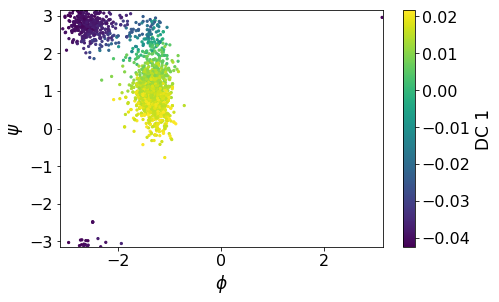

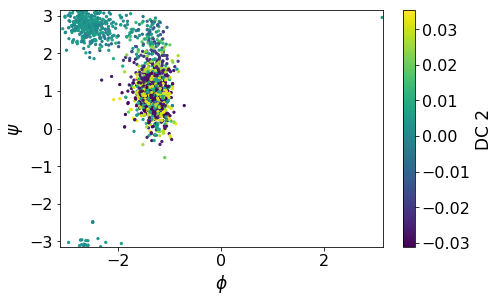

In [18]:
clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap.evecs[:,0], s=5)
plt.colorbar(clb, label='DC 1')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()


clb = plt.scatter(phi_torsion, psi_torsion, c=mydmap.evecs[:,1], s=5)
plt.colorbar(clb, label='DC 2')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$\psi$')
plt.show()

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


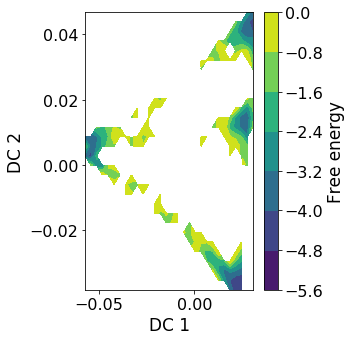

In [19]:
free_energy_dc, edx, edy = np.histogram2d(mydmap.dmap[:,0], mydmap.dmap[:,1], bins=30)

free_energy_dc = -np.log(free_energy_dc)

fig = plt.figure(figsize=(5,5))
clb = plt.contourf(edx[1:], edy[1:], free_energy_dc.T)
#plt.contourf([edx, edy,], free_energy_dc.T)
plt.colorbar(clb, label='Free energy')

plt.xlabel('DC 1')
plt.ylabel('DC 2')

plt.show()

Module features contains also functions to define list of features, comupte all the correlations with the diffusion coordinates and select the best ones.

In [20]:
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]

default_torsions = [phi, psi, zeta, theta]
all_combinations = features.create_torsions_list(atoms=traj.xyz.shape[1], size=100, append_to=default_torsions, print_list=True)


[[ 4  6  8 14]
 [ 6  8 14 16]
 [ 1  4  6  8]
 [ 8 14 16 18]
 [ 1  3 13 15]
 [ 0  3  5 11]
 [ 1 13 14 18]
 [ 5  6 12 14]
 [ 8 13 14 15]
 [ 0 10 13 16]
 [ 4  8 15 20]
 [ 2  3 14 20]
 [ 7 11 15 19]
 [ 5  6 18 21]
 [ 8 14 19 21]
 [ 1  3  9 16]
 [ 4  5 15 17]
 [ 3  7 14 17]
 [ 6  7 12 14]
 [ 7 10 16 17]
 [ 2  9 10 12]
 [ 5 11 16 20]
 [ 4  6  9 14]
 [ 6 12 15 21]
 [ 0  1  6 14]
 [ 6  7 10 21]
 [ 2  3 16 20]
 [ 5  9 11 12]
 [ 2  6 16 20]
 [ 1  7 18 20]
 [ 0  1  5 11]
 [ 2  7 18 20]
 [ 9 15 17 20]
 [12 17 18 21]
 [ 0  2 11 12]
 [ 1  6  8 15]
 [ 0  6  8 17]
 [ 0  4 19 21]
 [ 1 10 13 21]
 [ 2  8 16 19]
 [ 1  8 15 19]
 [ 4  5 15 20]
 [ 1  5  9 12]
 [ 0  1 11 14]
 [ 7  8 13 18]
 [10 15 16 19]
 [ 0  2 10 19]
 [ 2 11 12 19]
 [ 2  5  6 17]
 [ 0  5 12 21]
 [ 5  8 12 15]
 [ 8 11 16 18]
 [ 1  2 11 12]
 [ 0  5  8 21]
 [ 2  3  4 18]
 [ 2 13 16 20]
 [ 3 10 20 21]
 [ 1  8 15 16]
 [ 9 15 19 21]
 [ 8 10 11 15]
 [ 4  5  8 10]
 [ 2 15 18 21]
 [ 8 13 18 20]
 [ 2  7 10 20]
 [ 4  6 15 17]
 [ 0  6 14 20]
 [ 2  4  5

In [21]:
dimension = 2

list_of_functions =['compute_cos_torsion_mdraj' for _ in range(len(all_combinations))]
correlations = features.compute_all_correlations(traj, mydmap, dimension, list_of_functions, nevery=10, list_of_params=all_combinations)


Dimension 1


IntProgress(value=0, max=104)

Exception ignored in: <function DCDReporter.__del__ at 0x11a54c268>
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/site-packages/simtk/openmm/app/dcdreporter.py", line 108, in __del__
    self._out.close()
AttributeError: 'DCDReporter' object has no attribute '_out'
/miniconda3/lib/python3.7/site-packages/mdfeature-0.1.0-py3.7.egg/mdfeature/features.py:97: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta) * np.sign(np.dot(rkj, np.cross(t, u)))


Dimension 2


IntProgress(value=0, max=104)

In [22]:
# choose the two best ones
cv_indices, correlations_cv, cv_indices_2, correlations_cv_2 = features.identify_features(correlations, all_combinations, dimension)



Number of cvs:
103
Maximal cv:
index:
[ 1  8 15 16]
corr:
0.9358950666663236
Second naximal cv:
index:
[ 4  8 15 20]
corr:
0.9358896910505416
Number of cvs:
103
Maximal cv:
index:
[11 12 17 21]
corr:
0.8608600162908053
Second naximal cv:
index:
[ 5  8 12 15]
corr:
-0.5894616642177285


In [23]:
print(cv_indices)
print(correlations_cv)

[array([ 1,  8, 15, 16]), array([11, 12, 17, 21])]
[0.9358950666663236, 0.8608600162908053]


In [24]:
cv_indices_minimal, correlations_cv_minimal = features.identify_worst_features(correlations, all_combinations, dimension)


(104, 2)
[]
[]
[]
[ 2 26 69]


\Minimal correlated collective variables:
[array([1, 4, 6, 8]), array([ 2,  3, 16, 20])]
[2, 3, 16, 20]
Corr:
[[-0.02066137  0.02609269]
 [ 0.01715393  0.02486738]
 [ 0.02953175  0.02277928]]


/miniconda3/lib/python3.7/site-packages/mdfeature-0.1.0-py3.7.egg/mdfeature/features.py:392: RuntimeWarning: invalid value encountered in less
  inter = np.intersect1d(np.where(np.abs(corr_arr[:,0]) < eps)[0], np.where(np.abs(corr_arr[:,1]) < eps)[0])


In [25]:
torsion_max = features.compute_torsion_mdraj(traj, cv_indices[0])
torsion_max_1 = features.compute_torsion_mdraj(traj, cv_indices[1])

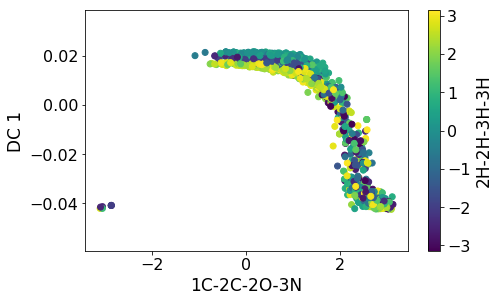

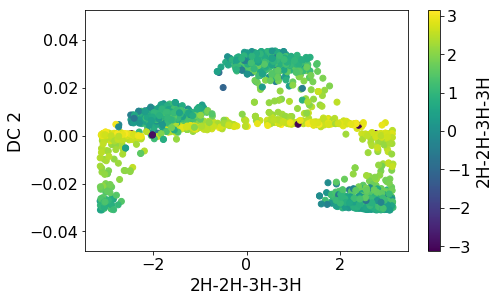

In [26]:
clb = plt.scatter(torsion_max, mydmap.evecs[:,0], c=torsion_max_1)
plt.colorbar(clb, label=(features.get_name_torsion(cv_indices[1], pdb_file=pdb_name, table=table, format='short')))
plt.xlabel(features.get_name_torsion(cv_indices[0], pdb_file=pdb_name, table=table, format='short'))
    
plt.ylabel('DC 1')
plt.show()

clb = plt.scatter(torsion_max_1, mydmap.evecs[:,1], c=torsion_max)
plt.colorbar(clb, label=(features.get_name_torsion(cv_indices[1], pdb_file=pdb_name, table=table, format='short')))
plt.xlabel((features.get_name_torsion(cv_indices[1], pdb_file=pdb_name, table=table, format='short')))
plt.ylabel('DC 2')
plt.show()

## Box standard metadynamics simulation using phi and psi as CVs

In [29]:
# def get_angle_name(phi_adapt, psi_adapt):
    
#     angle_name_1 = str(phi_adapt[0])+'_'+str(phi_adapt[1])+'_'+str(phi_adapt[2])+'_'+str(phi_adapt[3])
#     angle_name_2 = str(psi_adapt[0])+'_'+str(psi_adapt[1])+'_'+str(psi_adapt[2])+'_'+str(psi_adapt[3])

#     return angle_name_1 +'-'+ angle_name_2

In [27]:
import os.path
import metadynamics

def energy(x, simulation):
    simulation.context.setPositions(x)
    e = simulation.context.getState(getEnergy=True).getPotentialEnergy()
    return e 

class iMetadynamics():
    
    def __init__(self, positions, pdb, forcefield, system, cv_list, saving_file_meta, saving_file_energy=None):
        
        self.steps_meta = 100
        self.iterations = 50
        self.beta = 1.0/(300.0*0.0083144621)

        self.saving_file_meta = saving_file_meta
        self.pdb = pdb
        self.forcefield = forcefield
        self.system = system
        self.cv_list = cv_list 
        
        phi_adapt = cv_list[0]
        psi_adapt = cv_list[1]
        
        cv1 = CustomTorsionForce('theta')
        cv1.addTorsion(phi_adapt[0], phi_adapt[1], phi_adapt[2], phi_adapt[3])
        phi_meta = metadynamics.BiasVariable(cv1, -np.pi, np.pi, 0.5, True, gridWidth=60)
        cv2 = CustomTorsionForce('theta')
        cv2.addTorsion(psi_adapt[0], psi_adapt[1], psi_adapt[2], psi_adapt[3])
        psi_meta = metadynamics.BiasVariable(cv2, -np.pi, np.pi, 0.5, True, gridWidth=60)

        # Set up the simulation.
        self.meta = metadynamics.Metadynamics(system, [phi_meta, psi_meta], 300.0*kelvin, 1000.0, 1.0*kilojoules_per_mole, 100)
        integrator_meta = LangevinIntegrator(300*kelvin, 1.0/picosecond, 0.002*picoseconds)
        simulation_meta = Simulation(pdb.topology, system, integrator_meta, platform=Platform.getPlatformByName('CPU'))
        simulation_meta.context.setPositions(positions)
        simulation_meta.context.setVelocitiesToTemperature(300*kelvin)

        mdinit_meta = md.load_pdb(pdb_name)
        
        if os.path.exists(saving_file_meta):
            print(saving_file + " exists")
        else:
            mdinit_meta.save_dcd(saving_file_meta) 
            
        simulation_meta.reporters.append(DCDReporter(saving_file_meta, self.steps_meta, append=True))

        self.simulation_meta = simulation_meta
        
        print('Initialized metadynamics with cv:')
        print(cv_list)
        
        self.phi_adapt = phi_adapt
        self.psi_adapt = psi_adapt
        
        self.topology = mdinit_meta.topology
        print(energy(positions, simulation))
        print(mdinit_meta)
        
        self.saving_file_energy = saving_file_energy
        if self.saving_file_energy:
            if os.path.exists(self.saving_file_energy):
                print(self.saving_file_energy + " exists")
                
                
            else:
                with open(self.saving_file_energy, "w") as my_empty_csv:
                  # now you have an empty file already
                    pass
                my_empty_csv.close()
                
            simulation_meta.reporters.append(StateDataReporter(self.saving_file_energy, self.steps_meta, time=True, \
            kineticEnergy=True, potentialEnergy=True)) # .csv
              
       
    def run(self, steps=None, iterations=None):
        
        if steps is not None:
            self.steps_meta = steps
        if iterations is not None:
            self.iterations = iterations
    
        
        max_count = self.iterations
        bar = IntProgress(min=0, max=max_count) # instantiate the bar
        display(bar) # display the bar
        
        for i in range(self.iterations):
            bar.value += 1
            self.meta.step(self.simulation_meta, self.steps_meta)
        
        print('Done')
        


In [29]:
positions_unit = simulation.context.getState(getPositions=True).getPositions()

cv_list = [cv_indices[0].tolist(), cv_indices[1].tolist()]

saving_file_meta = 'trajectory_impl_meta.dcd'
saving_file_energy = 'energy_impl_meta.csv'

imeta = iMetadynamics(traj.xyz[-1], pdb, forcefield, system, cv_list, saving_file_meta, \
                      saving_file_energy=saving_file_energy)
imeta.run(iterations=1000)

trajectory.dcd exists
Initialized metadynamics with cv:
[[1, 8, 15, 16], [11, 12, 17, 21]]
146.2722333512309 kJ/mol
<mdtraj.Trajectory with 1 frames, 22 atoms, 3 residues, without unitcells>
energy_impl_meta.csv exists


IntProgress(value=0, max=1000)

Done


(60, 60)


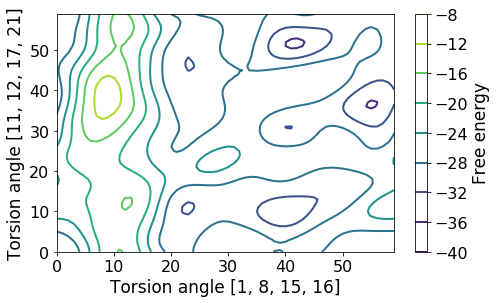

In [30]:
print(imeta.meta.getFreeEnergy().shape)
clb = plt.contour(imeta.meta.getFreeEnergy())
plt.colorbar(clb, label='Free energy')
plt.xlabel('Torsion angle '+str(imeta.phi_adapt))
plt.ylabel('Torsion angle '+str(imeta.psi_adapt))
plt.show()




In [31]:

phi_orig = [4, 6, 8, 14]
psi_orig = [6, 8, 14, 16]

traj_tmp = md.load_dcd(imeta.saving_file_meta, imeta.topology)

traj_tmp = traj_tmp.superpose(traj_tmp[0])
skip_first = 0
traj_meta = traj_tmp[1:]#[skip_first:]
print(traj_meta)

<mdtraj.Trajectory with 1368 frames, 22 atoms, 3 residues, without unitcells>


In [33]:
phi_torsion = features.compute_torsion_mdraj(traj_meta, phi_orig)
psi_torsion = features.compute_torsion_mdraj(traj_meta, psi_orig)

print(np.where(np.isnan(traj_meta.xyz)))
print(np.where(np.isnan(traj_meta.xyz)))

nan_idx_phi = np.where(np.isnan(phi_torsion))[0]
print(nan_idx_phi)

nan_idx_psi = np.where(np.isnan(psi_torsion))[0]
print(nan_idx_psi)

remove_idx = np.concatenate((nan_idx_phi, nan_idx_psi))
phi_torsion = np.array(phi_torsion)[np.setdiff1d(range(len(traj_meta)), remove_idx)]
psi_torsion = np.array(psi_torsion)[np.setdiff1d(range(len(traj_meta)), remove_idx)]

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
[]
[]


/miniconda3/lib/python3.7/site-packages/mdfeature-0.1.0-py3.7.egg/mdfeature/features.py:116: RuntimeWarning: divide by zero encountered in log
  FE =  - np.log(FE).T


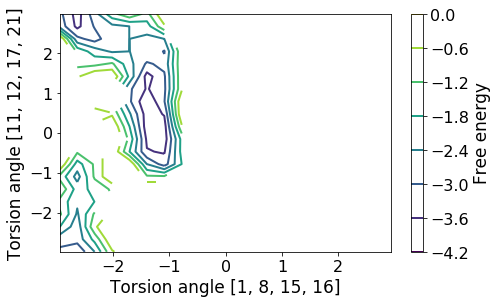

In [35]:
FE, xx, yy = features.compute_free_energy(phi_torsion, psi_torsion, bins=20)
clb = plt.contour(xx, yy, FE)

plt.colorbar(clb, label='Free energy')
plt.xlabel('Torsion angle '+str(imeta.phi_adapt))
plt.ylabel('Torsion angle '+str(imeta.psi_adapt))
#plt.savefig('Figures/alanine_meta_fe_biased'+angle_name+'.png',  format='png', dpi=None, bbox_inches='tight')
#plt.savefig('Figures/alanine_meta_fe_biased'+angle_name+'.pdf',  format='pdf', dpi=None, bbox_inches='tight')

plt.show()

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


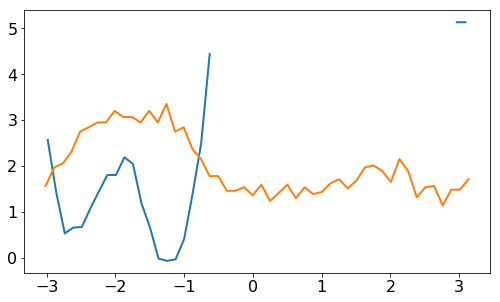

In [37]:
nbins = 50

vals, edges = np.histogram(phi_torsion, bins=nbins, density=True)
vals2, edges2 = np.histogram(psi_torsion, bins=nbins, density=True)

#valsl, edgesl = np.histogram(phi_long, bins=nbins, density=True)
#vals2l, edges2l = np.histogram(psi_long, bins=nbins, density=True)


plt.plot(edges[1:], -np.log(vals))
plt.plot(edges2[1:], -np.log(vals2))

#plt.plot(edgesl[1:], -np.log(valsl), '--')
#plt.plot(edges2l[1:], -np.log(vals2l), '--')

plt.show()
